In [1]:
import os
import random
import torch
import importlib
import src.util as util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 


In [2]:
path=os.getcwd()
path

'/media/data/home/darcy/master_summary'

In [3]:
file=pd.read_csv(path+'/datasets/air_quality_processed.csv')
file.info()
file=file.drop(columns=['Date','Time'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 11 columns):
Date             9357 non-null object
Time             9357 non-null object
PT08.S1(CO)      9005 non-null float64
C6H6(GT)         9005 non-null float64
PT08.S2(NMHC)    9005 non-null float64
PT08.S3(NOx)     9005 non-null float64
PT08.S4(NO2)     9005 non-null float64
PT08.S5(O3)      9005 non-null float64
T                9005 non-null float64
RH               9005 non-null float64
AH               9005 non-null float64
dtypes: float64(9), object(2)
memory usage: 804.2+ KB


In [4]:

data=(file-file[:7154].min())/(file[:7154].max()-file[:7154].min())
scale=[file[:7154].max().tolist(),file.min()[:7154].tolist()]


In [5]:
scale

[[2039.75,
  63.74147644829164,
  2214.0,
  2682.75,
  2775.0,
  2522.75,
  44.600000381470004,
  88.72500038147,
  2.2310357155831864],
 [647.25,
  0.14904773883376646,
  383.25,
  322.0,
  551.0,
  221.0,
  -1.8999999761581,
  9.1750001907349,
  0.1846790209991702]]

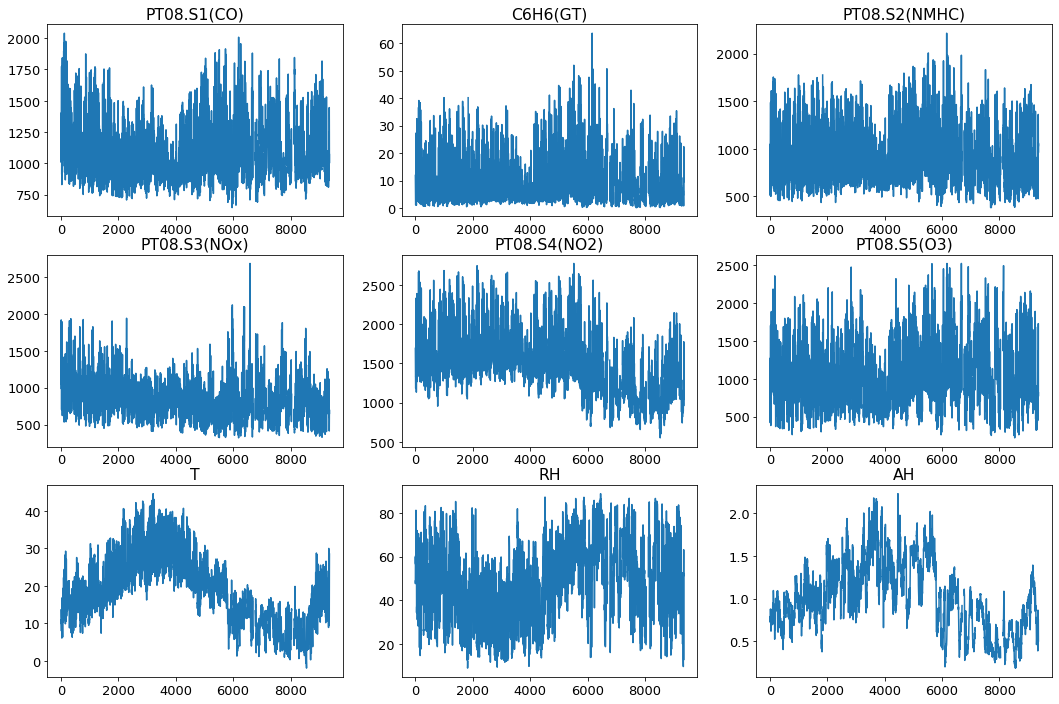

In [12]:
plt.rcParams.update({'font.size':13})
plt.figure(figsize=(18,12))
for i in range(len(data.columns)):
    plt.subplot(331+i)
    plt.plot(file[file.columns[i]])
    plt.title(file.columns[i])
#plt.legend(data.columns,loc='upper left')

In [5]:
cut_points=[0,701,725,1825,1839,2420,2458,4044,4089,4349,4368,6695,6770,7155,7207,7775,7784,8039,8115,9358]
len(cut_points)
count=0
pieces=[]
for i in range(0,20,2):
    pieces.append(data.iloc[cut_points[i]:cut_points[i+1]])
    count+=len(pieces[-1])
print(count)

9005


In [17]:
for piece in pieces:
    print(len(piece))

701
1100
581
1586
260
2327
385
568
255
1242


# generate inputs and outputs

In [6]:
def make_neighbor_list(target, input_dim):
    neighbors=[target]
    for i in range(input_dim):
        if i == target:
            continue
        else:
            neighbors.append(i)

    return neighbors

    
def make_io(input_len,output_len,neighbors,shuffle=True): #neighbors is a list 
    dataset1=[] #training dataset
    dataset2=[] #testing dataset
    package1=[[],[],[]]
    package2=[[],[],[]]
   
    
    for n in range(10):
        data1=pieces[n].values
        data_len=data1.shape[0]
        data_dim=data1.shape[1]
        for j in range(data_len-input_len-output_len):
            one_x=[]
            one_y=[]
            i=neighbors[0]
            s=[scale[0][i],scale[1][i]]
            for k in neighbors:
                    one_x.append(data1[j:j+input_len,k].reshape(input_len,-1))
                    one_y.append(data1[j+input_len:j+input_len+output_len,k].reshape(output_len,-1))
                
            one_x=np.concatenate(one_x,axis=1)
            one_y=np.concatenate(one_y,axis=1)
            one_data=[one_x.tolist(),one_y.tolist(),s]
            
            if n<7:
                dataset1.append(one_data)
            else:
                dataset2.append(one_data)
    if shuffle:
        random.shuffle(dataset1)
        random.shuffle(dataset2)
   
    for i in range(len(dataset1)):
        package1[0].append(dataset1[i][0])
        package1[1].append(dataset1[i][1])
        package1[2].append(dataset1[i][2])
    
    for i in range(len(dataset2)):
        package2[0].append(dataset2[i][0])
        package2[1].append(dataset2[i][1])
        package2[2].append(dataset2[i][2])
    #return dataset1,dataset2

    return package1, package2


In [7]:
input_len=24
output_len=12

input_dim=9
inputs=make_neighbor_list(0, input_dim)
dataset1,dataset2=make_io(input_len,output_len,inputs,False)
X_train=torch.FloatTensor(dataset1[0])
Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
X_test=torch.FloatTensor(dataset2[0])
Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
X_train.shape, X_test.shape

(torch.Size([6688, 24, 9]), torch.Size([1957, 24, 9]))

# training function 

In [7]:
def train(inputs, epochs, input_dim, input_len, output_len, model, loss_func, method, constrain=False):
    
    testing_mae=0
    testing_mape=0
    
    target=inputs[0]
    print(data.columns[target])
    
    
    dataset1,dataset2=make_io(input_len,output_len,inputs)
    dataset3,dataset4=make_io(input_len,output_len,inputs,False)

    X_train=torch.FloatTensor(dataset1[0])
    Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
    S_train=torch.FloatTensor(dataset1[2])

    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
    S_test=torch.FloatTensor(dataset2[2])

    X_train_valid=torch.FloatTensor(dataset3[0])
    Y_train_valid=torch.FloatTensor(dataset3[1])[:,:,0].unsqueeze(2)
    S_train_valid=torch.FloatTensor(dataset3[2])

    X_test_valid=torch.FloatTensor(dataset4[0])
    Y_test_valid=torch.FloatTensor(dataset4[1])[:,:,0].unsqueeze(2)
    S_test_valid=torch.FloatTensor(dataset4[2])
        
    model.to(gpu) #model放到gpu裡
    print('number of parmeters:', util.count_parameters(model))
    
    for j in range(epochs):
        if j<500:
            rate=0.001
        elif j>500 and j<2000:
            rate=0.0001
        else:
            rate=0.00001
            
        opt=torch.optim.Adam(model.parameters(),lr=rate)
        
        if constrain:
            model.weight.data.clamp_(0,1)
  
        #compute_loss(model, feature, label, batch, opt, train, loss_func, device)
        training_loss=util.compute_loss(model, X_train, Y_train, batch, opt, loss_func, train=True,device=gpu)
        testing_loss=util.compute_loss(model,X_test,Y_test,batch,opt, loss_func, train=False,device=gpu)
        
        #training_loss=util.compute_loss_ver2(model, X_train, Y_train, batch, opt, loss_func, train=True,device=gpu)
        #testing_loss=util.compute_loss_ver2(model,X_test,Y_test,batch,opt, loss_func, train=False,device=gpu)
        
        test_mape=util.mape(model(X_test.to(gpu))[:,:,0].to(cpu),Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        
        if j%100==0:
            print('epoch:'+str(j))
            print('training mae loss:'+str(training_loss))
            print('testing mae loss:'+str(testing_loss))
            print('testing mape:'+str(test_mape))
            if constrain:
                print(model.weight.data)
    
    
    model.to(cpu)   
     # plot_result(model, xs, ys, output_len, title, target_series, scale, save_path)
    util.plot_result(model, [X_train_valid,X_test_valid],[Y_train_valid,Y_test_valid],output_len,data.columns[target], target, 
                     scale, path+ '/results/plots/air_quality/'+method+'/')
    
    #plt.savefig(path+ '/results/plots/exchange_rate/'+data.columns[target]+'_prediction.png')
    #plt.clf()
    #    testing_mae+=testing_loss
    #    testing_mape+=mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    
   
    return X_train_valid, Y_train_valid, X_test_valid, Y_test_valid
    

# Set gpu and loss function

In [11]:
objective=torch.nn.L1Loss()
gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(gpu)
cpu=torch.device('cpu')

cuda:0


In [8]:
importlib.reload(util)

<module 'src.util' from '/media/data/home/darcy/master_summary/src/util.py'>

# train model

S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (7): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (8): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
  )
  (decoder): Decoder(
    (rnn): GRU(1, 80, batch_first=True)
    (fc1): Linear(in_features=80, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
PT08.S1(CO)
number of parmeters: 21413
epoch:0
training mae loss:0.3150283992290497
testing mae loss:0.30476856231689453
testing mape:0.36391446
epoch:100
training mae loss:

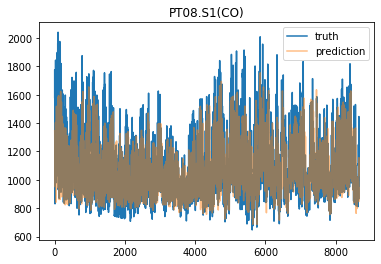

mae:  0.072479896
mape:  0.09123204
smape:  0.08939805


<Figure size 432x288 with 0 Axes>

In [14]:
import src.model

method='none'
targets=[0]
input_dim=9
cnn_hidden_size=4
cnn_kernel_size=4
cnn_parameters=(cnn_hidden_size,cnn_kernel_size)
fc_size=16
input_length=24
output_length=12

num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    model=src.model.S2S_cnn_attn(cnn_parameters,fc_size,input_dim,input_length,output_length, method)
    print(model)
 

    X_train, Y_train, X_test, Y_test=train(inputs,num_epochs,input_dim, input_length, output_length, model, objective, method)
    
    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print('mae: ',test_mae)
    
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('mape: ',test_mape)
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('smape: ',test_smape)
    
    #attention_weights.append(attns)

In [ ]:
torch.save(model, path+ '/results/models/'+method+'/'+data.columns[i]+'.pt')

basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(9, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
PT08.S1(CO)
number of parmeters: 10529
epoch:0
training mae loss:0.47950203716754913
testing mae loss:0.47854480147361755
testing mape:0.58967054
epoch:100
training mae loss:0.11474008485674858
testing mae loss:0.09988652169704437
testing mape:0.12393884
epoch:200
training mae loss:0.10919463634490967
testing mae loss:0.09901504218578339
testing mape:0.1254412
epoch:300
training mae loss:0.09606369584798813
testing mae loss:0.08835119754076004
testing mape:0.10871848
epoch:400
training mae loss:0.0929972492158413
testing mae loss:0.0892513170838356
testing mape:0.106784195
epoch:500
training mae loss:0.08644967153668404
testing mae loss:0.08322171866893768
testing mape:0.10089819
epoch:600
training mae loss:0.0808652974665165
testing mae loss:0.082612656

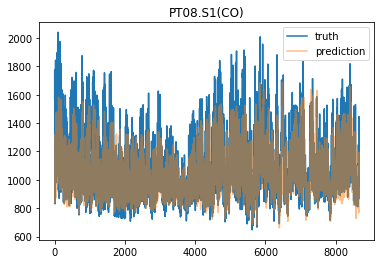

mae:  0.07617357
mape:  0.095295735
smape:  0.09397095
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(9, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
C6H6(GT)
number of parmeters: 10529
epoch:0
training mae loss:0.09367279335856438
testing mae loss:0.0789380818605423
testing mape:1.6310639
epoch:100
training mae loss:0.07581178843975067
testing mae loss:0.06771663576364517
testing mape:1.3253618
epoch:200
training mae loss:0.06512704119086266
testing mae loss:0.057593122124671936
testing mape:0.98011094
epoch:300
training mae loss:0.05905335023999214
testing mae loss:0.05658958479762077
testing mape:0.9634102
epoch:400
training mae loss:0.05642174370586872
testing mae loss:0.05582932010293007
testing mape:0.8965349
epoch:500
training mae loss:0.05371297337114811
testing mae loss:0.053673528134822845
testing mape:0.7903313
epoch:600
training mae lo

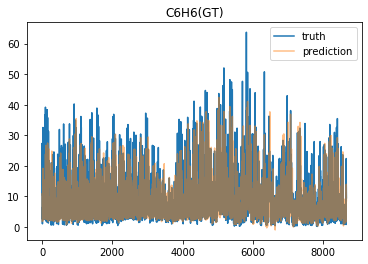

mae:  0.053402405
mape:  0.63042796
smape:  0.44340953
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(9, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
PT08.S2(NMHC)
number of parmeters: 10529
epoch:0
training mae loss:0.29710109531879425
testing mae loss:0.23377135396003723
testing mape:0.45356697
epoch:100
training mae loss:0.0937211886048317
testing mae loss:0.09416871517896652
testing mape:0.22437422
epoch:200
training mae loss:0.08536605536937714
testing mae loss:0.09505480527877808
testing mape:0.22992519
epoch:300
training mae loss:0.08090663328766823
testing mae loss:0.09042930603027344
testing mape:0.21740374
epoch:400
training mae loss:0.07586216554045677
testing mae loss:0.08242077380418777
testing mape:0.19236842
epoch:500
training mae loss:0.07493965700268745
testing mae loss:0.0864984467625618
testing mape:0.20562457
epoch:600
training

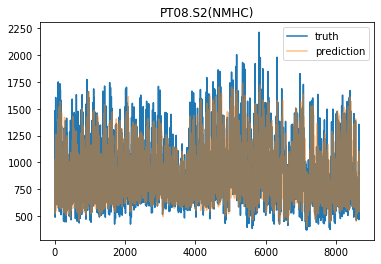

mae:  0.07235157
mape:  0.16053344
smape:  0.15276523
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(9, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
PT08.S3(NOx)
number of parmeters: 10529
epoch:0
training mae loss:0.24157585203647614
testing mae loss:0.19452553987503052
testing mape:0.5612751
epoch:100
training mae loss:0.07342508807778358
testing mae loss:0.07430486381053925
testing mape:0.26944578
epoch:200
training mae loss:0.06689150631427765
testing mae loss:0.06460338085889816
testing mape:0.23060477
epoch:300
training mae loss:0.06370574794709682
testing mae loss:0.05803932249546051
testing mape:0.19626833
epoch:400
training mae loss:0.060174938291311264
testing mae loss:0.05714012309908867
testing mape:0.19123709
epoch:500
training mae loss:0.05330834351480007
testing mae loss:0.060442641377449036
testing mape:0.21047452
epoch:600
trainin

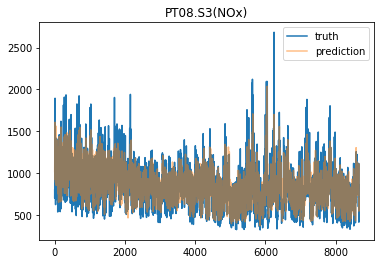

mae:  0.045942612
mape:  0.14714263
smape:  0.14287496
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(9, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
PT08.S4(NO2)
number of parmeters: 10529
epoch:0
training mae loss:0.3817698210477829
testing mae loss:0.18022537231445312
testing mape:0.34223047
epoch:100
training mae loss:0.1022072434425354
testing mae loss:0.13481852412223816
testing mape:0.3388452
epoch:200
training mae loss:0.09239188209176064
testing mae loss:0.10006778687238693
testing mape:0.24224731
epoch:300
training mae loss:0.08691132441163063
testing mae loss:0.09167703241109848
testing mape:0.21706177
epoch:400
training mae loss:0.08382860198616982
testing mae loss:0.0852799341082573
testing mape:0.19805765
epoch:500
training mae loss:0.07788443565368652
testing mae loss:0.0732225626707077
testing mape:0.16294904
epoch:600
training mae

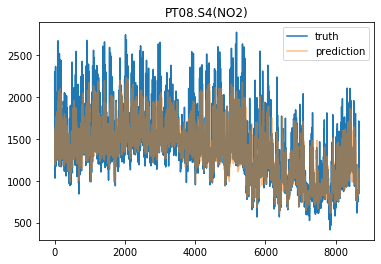

mae:  0.060360525
mape:  0.13220069
smape:  0.12767473
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(9, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
PT08.S5(O3)
number of parmeters: 10529
epoch:0
training mae loss:0.4074471592903137
testing mae loss:0.4099538326263428
testing mape:0.90730035
epoch:100
training mae loss:0.12116442620754242
testing mae loss:0.13410663604736328
testing mape:0.39604154
epoch:200
training mae loss:0.11757693067193031
testing mae loss:0.13181498646736145
testing mape:0.397738
epoch:300
training mae loss:0.11197344958782196
testing mae loss:0.12904192507266998
testing mape:0.40109804
epoch:400
training mae loss:0.10729917883872986
testing mae loss:0.12851130962371826
testing mape:0.39773348
epoch:500
training mae loss:0.09889236465096474
testing mae loss:0.12303085625171661
testing mape:0.35328558
epoch:600
training mae

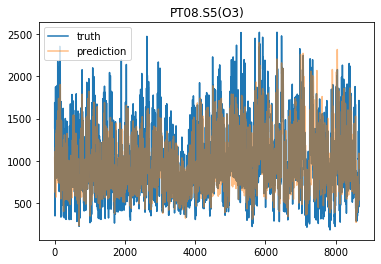

mae:  0.11452215
mape:  0.3293819
smape:  0.27498877
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(9, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
T
number of parmeters: 10529
epoch:0
training mae loss:0.7423102557659149
testing mae loss:0.4893977642059326
testing mape:13.037257
epoch:100
training mae loss:0.09628111869096756
testing mae loss:0.07994800060987473
testing mape:3.8079183
epoch:200
training mae loss:0.0873388908803463
testing mae loss:0.07650052011013031
testing mape:3.9308488
epoch:300
training mae loss:0.0828588679432869
testing mae loss:0.07195428013801575
testing mape:3.4099946
epoch:400
training mae loss:0.07525574415922165
testing mae loss:0.06818892806768417
testing mape:3.1924107
epoch:500
training mae loss:0.061844056472182274
testing mae loss:0.07154831290245056
testing mape:4.0527616
epoch:600
training mae loss:0.048145513

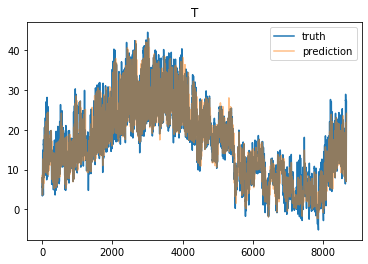

mae:  0.044131786
mape:  1.7167897
smape:  0.4502045
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(9, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
RH
number of parmeters: 10529
epoch:0
training mae loss:0.22497250139713287
testing mae loss:0.23658199608325958
testing mape:0.34043708
epoch:100
training mae loss:0.13120970875024796
testing mae loss:0.13981293141841888
testing mape:0.26587442
epoch:200
training mae loss:0.11619972065091133
testing mae loss:0.1263124644756317
testing mape:0.23753142
epoch:300
training mae loss:0.09407124295830727
testing mae loss:0.10800454020500183
testing mape:0.19212699
epoch:400
training mae loss:0.08764362707734108
testing mae loss:0.10171874612569809
testing mape:0.18149662
epoch:500
training mae loss:0.08035571500658989
testing mae loss:0.0994790643453598
testing mape:0.19221288
epoch:600
training mae loss:0.0

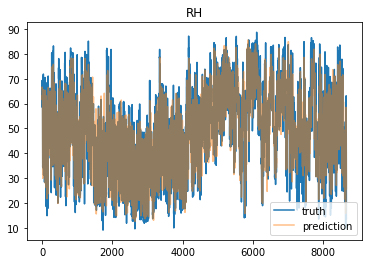

mae:  0.09229859
mape:  0.17435624
smape:  0.15382102
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(9, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
AH
number of parmeters: 10529
epoch:0
training mae loss:0.34600330889225006
testing mae loss:0.12187756597995758
testing mape:0.3470353
epoch:100
training mae loss:0.07867372408509254
testing mae loss:0.08198763430118561
testing mape:0.38726476
epoch:200
training mae loss:0.07147003710269928
testing mae loss:0.05851961299777031
testing mape:0.2572553
epoch:300
training mae loss:0.06692197173833847
testing mae loss:0.05016249790787697
testing mape:0.20815396
epoch:400
training mae loss:0.06349575147032738
testing mae loss:0.04605703800916672
testing mape:0.18628325
epoch:500
training mae loss:0.05692995525896549
testing mae loss:0.035268113017082214
testing mape:0.13206935
epoch:600
training mae loss:0

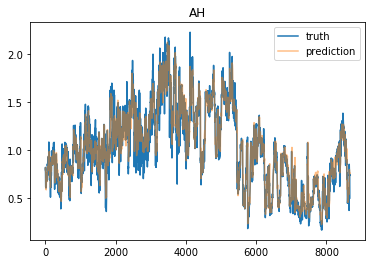

mae:  0.03251279
mape:  0.123939134
smape:  0.11257191


<Figure size 432x288 with 0 Axes>

In [9]:
import src.lstm_lstm

method=''
targets=[0,1,2,3,4,5,6,7,8]
input_dim=9
hidden_size=32
fc_size=16

input_length=24
output_length=12

num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    model=src.lstm_lstm.basic_S2S(hidden_size, fc_size, input_length, input_dim, output_length)
    print(model)
 

    X_train, Y_train, X_test, Y_test=train(inputs,num_epochs,input_dim, input_length, output_length, model, objective, method)
    
    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print('mae: ',test_mae)
    
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('mape: ',test_mape)
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('smape: ',test_smape)
    torch.save(model, path+ '/results/models/lstm/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 9), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
PT08.S1(CO)
number of parmeters: 7701
epoch:0
training mae loss:0.4522477090358734
testing mae loss:0.44146567583084106
testing mape:0.54126036
epoch:100
training mae loss:0.11287098005414009
testing mae loss:0.10294493287801743
testing mape:0.13171601
epoch:200
training mae loss:0.10648427903652191
testing mae loss:0.09928056597709656
testing mape:0.12612431
epoch:300
training mae loss:0.1011234000325203
testing mae loss:0.09365934878587723
testing mape:0.11715484
epoch:400
training mae loss:0.09650837257504463
testing mae loss:0.09048367291688919
testing mape:0.11311325
epoch:500
training mae loss:0.0888015553355217
testing mae loss:0.08810050040483475
testing ma

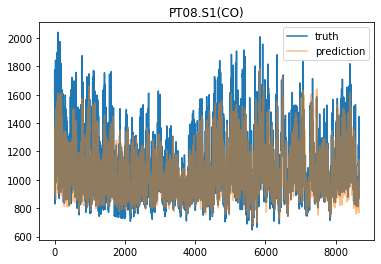

mae:  0.07519031
mape:  0.093338855
smape:  0.09265035
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 9), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
C6H6(GT)
number of parmeters: 7701
epoch:0
training mae loss:0.30235666036605835
testing mae loss:0.2543392777442932
testing mape:3.4862568
epoch:100
training mae loss:0.08448385819792747
testing mae loss:0.07716194540262222
testing mape:1.7162386
epoch:200
training mae loss:0.07545813918113708
testing mae loss:0.07344675809144974
testing mape:1.6759083
epoch:300
training mae loss:0.0643690899014473
testing mae loss:0.05691841244697571
testing mape:0.9436175
epoch:400
training mae loss:0.06058822572231293
testing mae loss:0.05281020700931549
testing mape:0.849278
epoch:500
training mae loss:0.05722981318831444


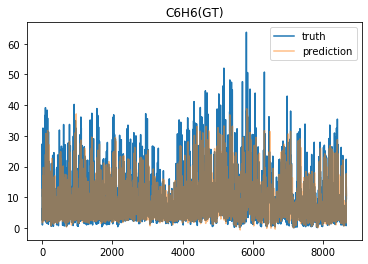

mae:  0.05121145
mape:  0.7367819
smape:  0.43632802
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 9), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
PT08.S2(NMHC)
number of parmeters: 7701
epoch:0
training mae loss:0.4555539935827255
testing mae loss:0.3927278220653534
testing mape:0.82349145
epoch:100
training mae loss:0.11299476400017738
testing mae loss:0.11573363840579987
testing mape:0.28515443
epoch:200
training mae loss:0.10935401171445847
testing mae loss:0.10920433700084686
testing mape:0.2644997
epoch:300
training mae loss:0.10255921259522438
testing mae loss:0.10219717025756836
testing mape:0.24492161
epoch:400
training mae loss:0.09663008525967598
testing mae loss:0.09684275835752487
testing mape:0.22708009
epoch:500
training mae loss:0.0876825898

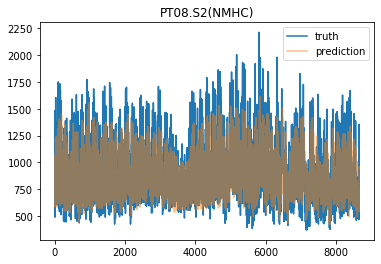

mae:  0.07339347
mape:  0.1674586
smape:  0.15691061
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 9), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
PT08.S3(NOx)
number of parmeters: 7701
epoch:0
training mae loss:0.3900892585515976
testing mae loss:0.34092962741851807
testing mape:1.0537424
epoch:100
training mae loss:0.07684317231178284
testing mae loss:0.07314060628414154
testing mape:0.2523063
epoch:200
training mae loss:0.07207204028964043
testing mae loss:0.06612944602966309
testing mape:0.22125389
epoch:300
training mae loss:0.07043861970305443
testing mae loss:0.0637734979391098
testing mape:0.20817508
epoch:400
training mae loss:0.06944939866662025
testing mae loss:0.06277476251125336
testing mape:0.20383395
epoch:500
training mae loss:0.066837310791

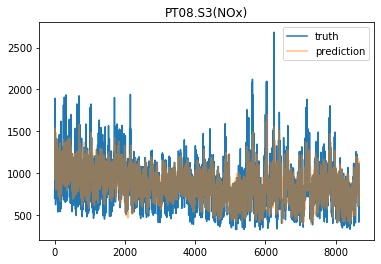

mae:  0.048952952
mape:  0.15634637
smape:  0.15240724
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 9), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
PT08.S4(NO2)
number of parmeters: 7701
epoch:0
training mae loss:0.4078587293624878
testing mae loss:0.2070140689611435
testing mape:0.40023676
epoch:100
training mae loss:0.10394076257944107
testing mae loss:0.13122498989105225
testing mape:0.333584
epoch:200
training mae loss:0.09882011637091637
testing mae loss:0.09213456511497498
testing mape:0.21600725
epoch:300
training mae loss:0.09616562724113464
testing mae loss:0.08428133279085159
testing mape:0.1909044
epoch:400
training mae loss:0.09387282282114029
testing mae loss:0.08060645312070847
testing mape:0.18140087
epoch:500
training mae loss:0.08759673312

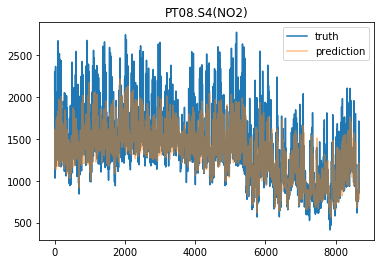

mae:  0.06148966
mape:  0.13001831
smape:  0.12889369
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 9), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
PT08.S5(O3)
number of parmeters: 7701
epoch:0
training mae loss:0.2098943367600441
testing mae loss:0.214460089802742
testing mape:0.4392393
epoch:100
training mae loss:0.11905726045370102
testing mae loss:0.13119995594024658
testing mape:0.39096656
epoch:200
training mae loss:0.11370168626308441
testing mae loss:0.12903562188148499
testing mape:0.3857237
epoch:300
training mae loss:0.11056007444858551
testing mae loss:0.12574400007724762
testing mape:0.3721039
epoch:400
training mae loss:0.10845120623707771
testing mae loss:0.12501049041748047
testing mape:0.37240452
epoch:500
training mae loss:0.10371933877468

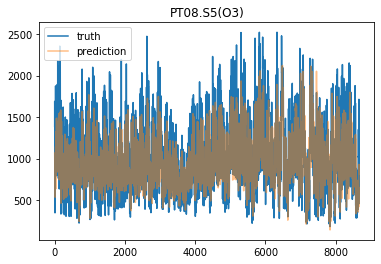

mae:  0.10725348
mape:  0.31168818
smape:  0.26026
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 9), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
T
number of parmeters: 7701
epoch:0
training mae loss:0.7183160781860352
testing mae loss:0.4598679542541504
testing mape:11.894455
epoch:100
training mae loss:0.10192358866333961
testing mae loss:0.09061834216117859
testing mape:4.989163
epoch:200
training mae loss:0.09718652069568634
testing mae loss:0.0796213150024414
testing mape:3.6823447
epoch:300
training mae loss:0.09472514688968658
testing mae loss:0.0766904205083847
testing mape:3.319838
epoch:400
training mae loss:0.09215806052088737
testing mae loss:0.07528939843177795
testing mape:3.1443949
epoch:500
training mae loss:0.08432690426707268
testing mae lo

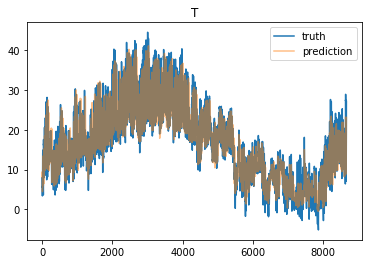

mae:  0.045722984
mape:  2.0415342
smape:  0.4613607
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 9), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
RH
number of parmeters: 7701
epoch:0
training mae loss:0.8273538947105408
testing mae loss:0.857681155204773
testing mape:1.3486663
epoch:100
training mae loss:0.1496848315000534
testing mae loss:0.15037141740322113
testing mape:0.27752212
epoch:200
training mae loss:0.14454768598079681
testing mae loss:0.14553044736385345
testing mape:0.27873862
epoch:300
training mae loss:0.1405906155705452
testing mae loss:0.1417057067155838
testing mape:0.27552345
epoch:400
training mae loss:0.13117405027151108
testing mae loss:0.1351102888584137
testing mape:0.2706597
epoch:500
training mae loss:0.11809754744172096
testing m

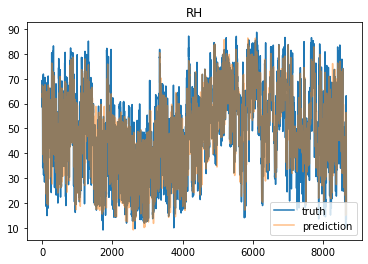

mae:  0.09308837
mape:  0.17425102
smape:  0.15468599
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 9), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
AH
number of parmeters: 7701
epoch:0
training mae loss:0.2919127643108368
testing mae loss:0.10671565681695938
testing mape:0.37251347
epoch:100
training mae loss:0.06773899123072624
testing mae loss:0.059285711497068405
testing mape:0.26674408
epoch:200
training mae loss:0.06298978626728058
testing mae loss:0.05148889496922493
testing mape:0.21762182
epoch:300
training mae loss:0.060712723061442375
testing mae loss:0.050910256803035736
testing mape:0.21324684
epoch:400
training mae loss:0.059123095124959946
testing mae loss:0.05045944079756737
testing mape:0.2099705
epoch:500
training mae loss:0.054507756605744

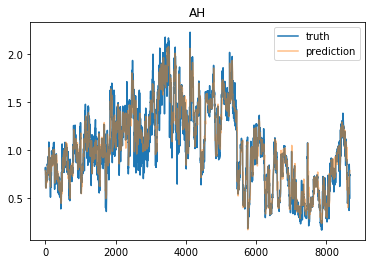

mae:  0.033620957
mape:  0.13022086
smape:  0.11703999


<Figure size 432x288 with 0 Axes>

In [11]:
import src.two_dim_cnn_gru

method=""

targets=[0,1,2,3,4,5,6,7,8]
input_dim=9

hidden_size=32
fc_size=16
input_length=24
output_length=12

cnn_hidden_size=4
cnn_kernel_size=4
cnn_parameters=(cnn_hidden_size,cnn_kernel_size)

num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    #S2S_2dcnn(cnn_parameters,rnn_hidden_size,fc_size,input_dim,output_length)
    model=src.two_dim_cnn_gru.S2S_2dcnn(cnn_parameters,hidden_size,fc_size,input_dim,output_length)
    print(model)
    
    X_train, Y_train, X_test, Y_test=train(inputs,num_epochs,input_dim, input_length, output_length, model, objective, method)
    
    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print('mae: ',test_mae)
    
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('mape: ',test_mape)
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('smape: ',test_smape)
    # plot_attention(model, X_train, X_test, column_names, neighbors, save_path)
    #attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/')

    
    torch.save(model, path+ '/results/models/2dcnn/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

In [15]:
X_train.shape

torch.Size([6688, 24, 9])

# show results

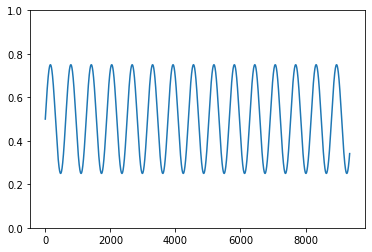

In [7]:

method='general'
#noise=pd.read_csv('noise.csv')
mu=0.5
sigma=0.05
noise=0.25*np.sin([0.01*i for i in range(len(file))])+0.5#*np.random.normal(mu, sigma, len(file))+0.1
#noise=np.expand_dims(noise, axis=1)
plt.ylim(0,1)
plt.plot(noise)

/usr/bin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'src.model.S2S_cnn_attn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/bin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'src.model.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


PT08.S1(CO)
orignial mae: 0.07034442
orignial test smape: 0.086794
original train smape: 0.081170365


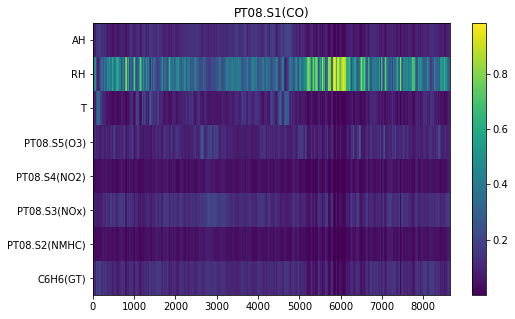

[[4, 0.03699632315756301], [2, 0.03819660695332046], [6, 0.05309296486954936], [8, 0.07227673086608528], [1, 0.09884022737557699], [5, 0.10892081721060028], [3, 0.11457380841880671], [7, 0.4771025210283944]]
0 0
1 0.09138198
2 0.08715553
3 0.08651743
4 0.086793706
5 0.09386678
6 0.08653209
7 0.09310323
8 0.08620424
C6H6(GT)
orignial mae: 0.04882666
orignial test smape: 0.43596607
original train smape: 0.33552918


<Figure size 432x288 with 0 Axes>

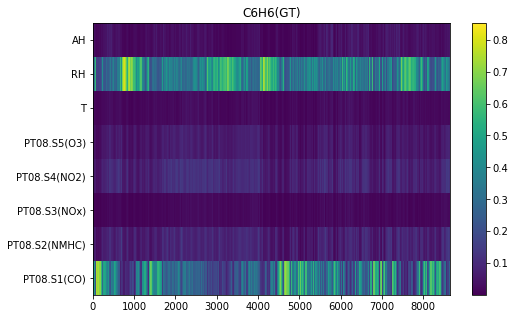

[[3, 0.020503553252892763], [6, 0.02710563052677886], [8, 0.04385082117878148], [5, 0.05749911809407696], [2, 0.08570522521743831], [4, 0.09002764852537631], [0, 0.24290417663098204], [7, 0.4324038256079674]]
0 0.43884683
1 1
2 0.43440026
3 0.436528
4 0.43705967
5 0.43485093
6 0.4350278
7 0.44772816
8 0.43594176
PT08.S2(NMHC)
orignial mae: 0.0688743
orignial test smape: 0.14809129
original train smape: 0.12172559


<Figure size 432x288 with 0 Axes>

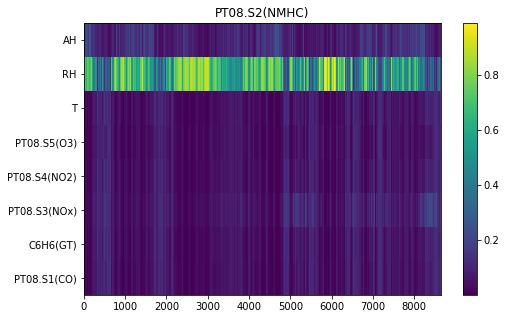

[[5, 0.04870073456573812], [0, 0.05010539156107083], [1, 0.05147601017054108], [6, 0.05148961173236814], [4, 0.05180592022560012], [3, 0.07946808799830259], [8, 0.09569065594940038], [7, 0.5712635876362459]]
0 0.15077409
1 0.15312131
2 2
3 0.14765556
4 0.1480694
5 0.15243474
6 0.14747903
7 0.15694107
8 0.15000303
PT08.S3(NOx)
orignial mae: 0.046158615
orignial test smape: 0.14187467
original train smape: 0.12637061


<Figure size 432x288 with 0 Axes>

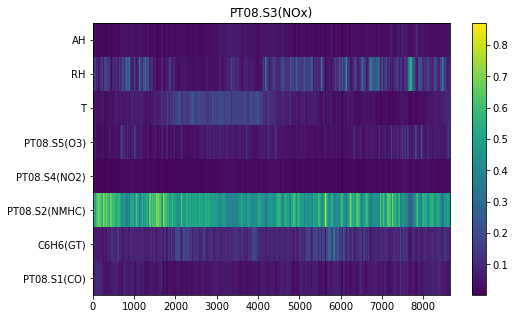

[[4, 0.030690856885658], [8, 0.04777190139670426], [6, 0.049833035293545845], [0, 0.06719531465129519], [5, 0.08102730570544713], [1, 0.11485943092746155], [7, 0.153765512903506], [2, 0.45485664367310297]]
0 0.18023033
1 0.3721734
2 0.26111862
3 3
4 0.14186507
5 0.1586632
6 0.14229481
7 0.1473138
8 0.14150551
PT08.S4(NO2)
orignial mae: 0.058056902
orignial test smape: 0.12244242
original train smape: 0.09621249


<Figure size 432x288 with 0 Axes>

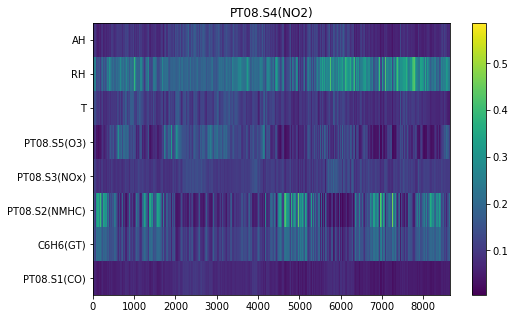

[[0, 0.05629792540987566], [8, 0.08624144486310108], [6, 0.09619562084204576], [5, 0.10462664557962574], [2, 0.11641488703420813], [3, 0.12142738029474985], [1, 0.13234291081571373], [7, 0.28645318593900304]]
0 0.12253971
1 0.1226666
2 0.12474594
3 0.12345972
4 4
5 0.1264723
6 0.12342184
7 0.13227563
8 0.124226205
PT08.S5(O3)
orignial mae: 0.10083563
orignial test smape: 0.24898243
original train smape: 0.1980012


<Figure size 432x288 with 0 Axes>

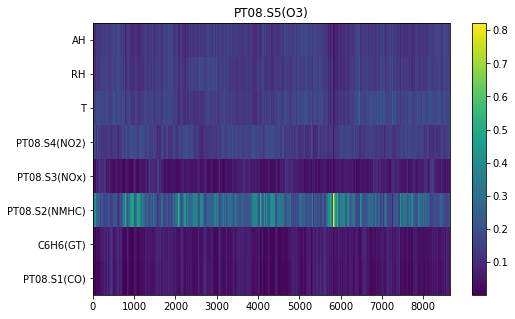

[[0, 0.04286123575608441], [1, 0.04795481451890799], [3, 0.054570320193923716], [8, 0.12604287229992323], [7, 0.13688866241692765], [4, 0.1451766623424887], [6, 0.16042454537683806], [2, 0.28608088618678346]]
0 0.24762037
1 0.24733607
2 0.26934654
3 0.25315815
4 0.2455341
5 5
6 0.2463104
7 0.24993432
8 0.25322855
T
orignial mae: 0.040931676
orignial test smape: 0.43581426
original train smape: 0.12161311


<Figure size 432x288 with 0 Axes>

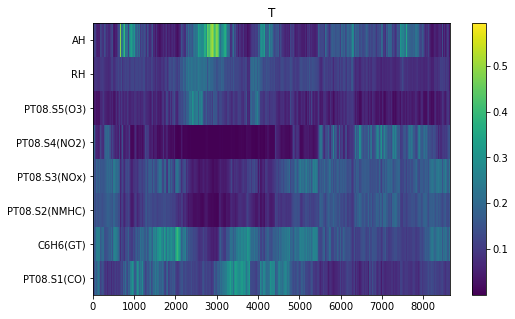

[[5, 0.0582834850653138], [0, 0.09293690054283864], [7, 0.09415654372090762], [1, 0.1276941539402756], [2, 0.13657789478458246], [4, 0.14278110755606535], [3, 0.15134461773640354], [8, 0.1962252960025914]]
0 0.4421349
1 0.44273502
2 0.4678399
3 0.44755352
4 0.5591178
5 0.4389561
6 6
7 0.43522406
8 0.44445226
RH
orignial mae: 0.08994975
orignial test smape: 0.149575
original train smape: 0.12787154


<Figure size 432x288 with 0 Axes>

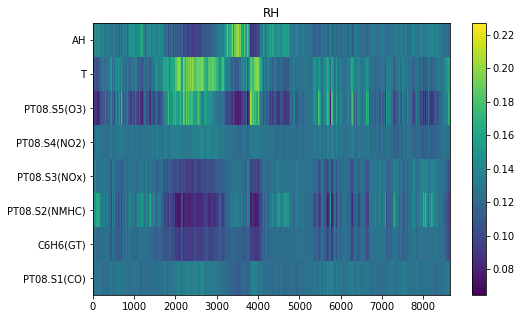

[[2, 0.11691646995931848], [1, 0.11738879928783184], [3, 0.12052923538396111], [4, 0.12559957930596433], [8, 0.125852557317024], [0, 0.12880954876976106], [5, 0.13161650211700202], [6, 0.13328730681597972]]
0 0.15256537
1 0.17109461
2 0.1533284
3 0.15516332
4 0.15554869
5 0.15725471
6 0.16977558
7 7
8 0.15742292
AH
orignial mae: 0.032212775
orignial test smape: 0.113763504
original train smape: 0.08579906


<Figure size 432x288 with 0 Axes>

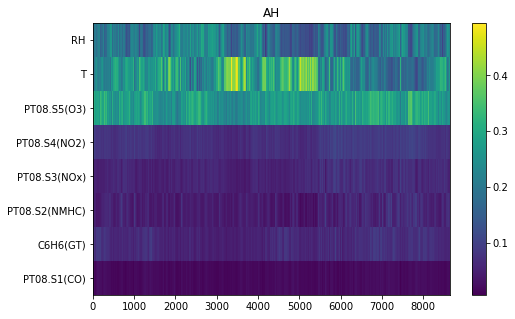

[[0, 0.018680598973222818], [2, 0.06344501113954039], [1, 0.06667923243734443], [3, 0.07231643821094252], [4, 0.09118986826468074], [6, 0.20006291460537093], [7, 0.20137610482542137], [5, 0.2862498313188553]]
0 0.11371828
1 0.11781419
2 0.11467201
3 0.11409619
4 0.11356685
5 0.12740038
6 0.12444393
7 0.11827803
8 8


<Figure size 432x288 with 0 Axes>

In [8]:
feature_importance=[]
ranks=[]
original_smape=0

for i in range(9):
    file_name=data.columns[i]
    model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
    print(file_name)
    inputs=make_neighbor_list(target=i, input_dim=9)
    data=(file-file[:7154].min())/(file[:7154].max()-file[:7154].min())
    pieces=[]
    for j in range(0,20,2):
        pieces.append(data.iloc[cut_points[j]:cut_points[j+1]])
        
#make_io(input_len,output_len,neighbors,shuffle=True)
    dataset1, dataset2=make_io(input_len=24,output_len=12,neighbors=inputs, shuffle=False)
    X_train=torch.FloatTensor(dataset1[0])
    Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)

    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    train_smape=util.smape(model(X_train)[:,:,0],Y_train[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    
    print("orignial mae:",test_mae)
    print("orignial test smape:",test_smape)
    print("original train smape:", train_smape)
    original_smape+=test_smape
    #original_smape+=train_smape
    
    attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/air_quality/'+method+'/')
#attns
    attns=np.array(attns)
    importance=[]
    for k in range(1,9):
        
        importance.append([inputs[k], attns[6688:,k-1].mean()])
        #importance.append([inputs[k], attns[:6688,k-1].mean()])
    sorted_importance=sorted(importance, key= lambda importance: importance[1])
    print(sorted_importance)

    rank=[sorted_importance[k][0] for k in range(8)]
    ranks.append(rank)
    smape=[]
    #for k in rank:
    for k in range(9):
        if k==i:
            print(i,k)
            smape.append(0)
            continue
        data=(file-file[:7154].min())/(file[:7154].max()-file[:7154].min())
        #data[data.columns[k]]=np.random.permutation(data[data.columns[k]])
        #data[data.columns[k]]=data[data.columns[k]].fillna(data[data.columns[k]].mean())
        data[data.columns[k]]=pd.DataFrame(noise)
        pieces=[]
        for j in range(0,20,2):
            pieces.append(data.iloc[cut_points[j]:cut_points[j+1]])
    
        dataset1, dataset2=make_io(input_len=24,output_len=12,neighbors=inputs, shuffle=False)
        X_train=torch.FloatTensor(dataset1[0])
        Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
        X_test=torch.FloatTensor(dataset2[0])
        Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
        #train_smape=util.smape(model(X_train)[:,:,0],Y_train[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        
        #print(str(k),train_smape)
        #smape.append(train_smape)
        
        print(str(k),test_smape)
        smape.append(test_smape)
        #truth.append([k,test_smape])
    feature_importance.append(smape)

In [9]:
FI=pd.DataFrame(feature_importance)#.transpose()
#ranking=pd.DataFrame(ranks)
FI

,0,1,2,3,4,5,6,7,8
0,0.000000,0.091382,0.087156,0.086517,0.086794,0.093867,0.086532,0.093103,0.086204
1,0.438847,0.000000,0.434400,0.436528,0.437060,0.434851,0.435028,0.447728,0.435942
2,0.150774,0.153121,0.000000,0.147656,0.148069,0.152435,0.147479,0.156941,0.150003
3,0.180230,0.372173,0.261119,0.000000,0.141865,0.158663,0.142295,0.147314,0.141506
4,0.122540,0.122667,0.124746,0.123460,0.000000,0.126472,0.123422,0.132276,0.124226
5,0.247620,0.247336,0.269347,0.253158,0.245534,0.000000,0.246310,0.249934,0.253229
6,0.442135,0.442735,0.467840,0.447554,0.559118,0.438956,0.000000,0.435224,0.444452
7,0.152565,0.171095,0.153328,0.155163,0.155549,0.157255,0.169776,0.000000,0.157423
8,0.113718,0.117814,0.114672,0.114096,0.113567,0.127400,0.124444,0.118278,0.000000


In [10]:
ranks

[[4, 2, 6, 8, 1, 5, 3, 7],
 [3, 6, 8, 5, 2, 4, 0, 7],
 [5, 0, 1, 6, 4, 3, 8, 7],
 [4, 8, 6, 0, 5, 1, 7, 2],
 [0, 8, 6, 5, 2, 3, 1, 7],
 [0, 1, 3, 8, 7, 4, 6, 2],
 [5, 0, 7, 1, 2, 4, 3, 8],
 [2, 1, 3, 4, 8, 0, 5, 6],
 [0, 2, 1, 3, 4, 6, 7, 5]]

In [11]:
col_dict={file.columns[i]:i for i in range(9)}
#corr=file[:7207].corr()
corr=file.iloc[7207:].corr()
col_dict

{'PT08.S1(CO)': 0,
 'C6H6(GT)': 1,
 'PT08.S2(NMHC)': 2,
 'PT08.S3(NOx)': 3,
 'PT08.S4(NO2)': 4,
 'PT08.S5(O3)': 5,
 'T': 6,
 'RH': 7,
 'AH': 8}

In [13]:
corr

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
PT08.S1(CO),1.000000,0.890520,0.899859,-0.745051,0.763373,0.895281,0.017407,0.093548,0.118310
C6H6(GT),0.890520,1.000000,0.982602,-0.757407,0.801026,0.883528,0.137319,-0.062616,0.103893
PT08.S2(NMHC),0.899859,0.982602,1.000000,-0.819336,0.807536,0.893967,0.178852,-0.097694,0.115381
PT08.S3(NOx),-0.745051,-0.757407,-0.819336,1.000000,-0.667008,-0.783568,-0.224793,-0.026130,-0.340648
PT08.S4(NO2),0.763373,0.801026,0.807536,-0.667008,1.000000,0.668897,0.410232,-0.049902,0.486201
PT08.S5(O3),0.895281,0.883528,0.893967,-0.783568,0.668897,1.000000,-0.051438,0.111359,0.068157
T,0.017407,0.137319,0.178852,-0.224793,0.410232,-0.051438,1.000000,-0.674489,0.534082
RH,0.093548,-0.062616,-0.097694,-0.026130,-0.049902,0.111359,-0.674489,1.000000,0.202989
AH,0.118310,0.103893,0.115381,-0.340648,0.486201,0.068157,0.534082,0.202989,1.000000


In [12]:
correlation_ranking=[]
for i in range(9):
    rank=[col_dict[abs(corr[corr.columns[i]]).sort_values().index[j]] for j in range(8)]
    correlation_ranking.append(rank)
correlation_ranking    

[[7, 6, 8, 3, 1, 5, 2, 4],
 [7, 8, 6, 3, 4, 5, 0, 2],
 [7, 8, 6, 4, 3, 5, 0, 1],
 [7, 6, 8, 1, 5, 4, 2, 0],
 [7, 6, 8, 5, 1, 3, 2, 0],
 [6, 7, 8, 4, 3, 1, 2, 0],
 [5, 1, 2, 0, 7, 3, 4, 8],
 [2, 1, 3, 5, 0, 4, 6, 8],
 [1, 2, 5, 0, 3, 7, 6, 4]]

In [15]:
FI.iloc[0][1]

0.08426661789417267

In [13]:
model_importance=[]
correlation_importance=[]
for i in range(9):
    model_importance.append([original_smape/9]+[FI.iloc[i][j] for j in ranks[i]])
    correlation_importance.append([original_smape/9]+[FI.iloc[i][j] for j in correlation_ranking[i]])
    

In [14]:
pd.DataFrame(correlation_importance)

,0,1,2,3,4,5,6,7,8
0,0.209256,0.093103,0.086532,0.086204,0.086517,0.091382,0.093867,0.087156,0.086794
1,0.209256,0.447728,0.435942,0.435028,0.436528,0.437060,0.434851,0.438847,0.434400
2,0.209256,0.156941,0.150003,0.147479,0.148069,0.147656,0.152435,0.150774,0.153121
3,0.209256,0.147314,0.142295,0.141506,0.372173,0.158663,0.141865,0.261119,0.180230
4,0.209256,0.132276,0.123422,0.124226,0.126472,0.122667,0.123460,0.124746,0.122540
5,0.209256,0.246310,0.249934,0.253229,0.245534,0.253158,0.247336,0.269347,0.247620
6,0.209256,0.438956,0.442735,0.467840,0.442135,0.435224,0.447554,0.559118,0.444452
7,0.209256,0.153328,0.171095,0.155163,0.157255,0.152565,0.155549,0.169776,0.157423
8,0.209256,0.117814,0.114672,0.127400,0.113718,0.114096,0.118278,0.124444,0.113567


## feature importance with noise

([<matplotlib.axis.XTick at 0x7f5bf90ac590>,
 <a list of 9 Text xticklabel objects>)

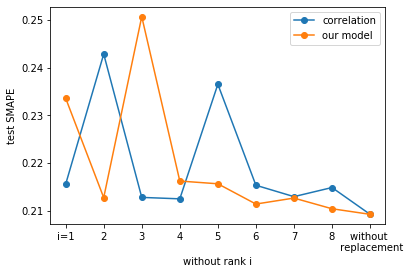

In [15]:
ticks=[str(i) for i in range(1,10)]
ticks[0]="i=1"
ticks[-1]="without \n replacement"

plt.plot(pd.DataFrame(correlation_importance).mean().tolist()[::-1],'-o')
plt.plot(pd.DataFrame(model_importance).mean().tolist()[::-1],'-o')
#plt.ylabel("train SMAPE")
plt.ylabel("test SMAPE")
plt.xlabel("without rank i")
plt.legend(["correlation","our model"])
plt.xticks([i for i in range(9)],ticks)

In [46]:
np.corrcoef(pd.DataFrame(correlation_importance).mean().tolist()[::-1],[i for i in range(9)])

array([[ 1.        , -0.65341342],
       [-0.65341342,  1.        ]])

In [47]:
np.corrcoef(pd.DataFrame(model_importance).mean().tolist()[::-1],[i for i in range(9)])

array([[ 1.        , -0.69614585],
       [-0.69614585,  1.        ]])

In [16]:
from scipy import stats
stats.kendalltau(pd.DataFrame(correlation_importance).mean().tolist()[::-1],[i for i in range(9)])

KendalltauResult(correlation=-0.3888888888888889, pvalue=0.18018077601410934)

In [17]:
stats.kendalltau(pd.DataFrame(model_importance).mean().tolist()[::-1],[i for i in range(9)])

KendalltauResult(correlation=-0.7222222222222222, pvalue=0.0058862433862433864)

In [9]:
method='none'
for i in range(9):
    file_name=data.columns[i]
    print(file_name)
    model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
    inputs=make_neighbor_list(target=i, input_dim=9)

    dataset1, dataset2=make_io(input_len=24,output_len=12,neighbors=inputs, shuffle=False)
    X_train=torch.FloatTensor(dataset1[0])
    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)

    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print('mae: ',test_mae)
    
    #test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    #print(test_mape)
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('smape: ',test_smape)

PT08.S1(CO)
mae:  0.071170166
smape:  0.0880355
C6H6(GT)
mae:  0.04930281
smape:  0.44449943
PT08.S2(NMHC)
mae:  0.07069118
smape:  0.15136755
PT08.S3(NOx)
mae:  0.048555955
smape:  0.15038584
PT08.S4(NO2)
mae:  0.059084814
smape:  0.12451764
PT08.S5(O3)
mae:  0.10472481
smape:  0.25691825
T
mae:  0.042424913
smape:  0.43852556
RH
mae:  0.09170639
smape:  0.15331063
AH
mae:  0.032946404
smape:  0.11318742


# first/last performance

In [31]:

def first_last(method, step):
    #mae=0
    #smape=0
    mae=[]
    smape=[]
    for i in range(9):
        file_name=data.columns[i]
        model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
        inputs=make_neighbor_list(target=i, input_dim=9)
        _, dataset2=make_io(input_len=24,output_len=12,neighbors=inputs, shuffle=False)
  
        X_test=torch.FloatTensor(dataset2[0])
        Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
        mae.append(util.mae(model(X_test)[:,step,:],Y_test[:,step,:]))
        smape.append(util.smape(model(X_test)[:,step,:],Y_test[:,step,:],(scale[0][i]-scale[1][i]),scale[1][i]))
    return mae, smape
        #mae+=abs(model(X_test)[:,step,:]-Y_test[:,step,:]).mean()
        #smape+=util.smape(model(X_test)[:,step,:],Y_test[:,step,:],(scale[0][i]-scale[1][i]),scale[1][i])
    #return mae.item()/9, smape/9

In [10]:
model_names=['bahdanau','dot','general','none','lstm','2dcnn']

In [32]:
model_names=['bahdanau','dot','general','none','lstm','2dcnn']
for name in model_names:
    first=first_last(name, 0)
    #last=first_last(name, -1)
    print(name, "mae:",np.mean(first[0]),"/",np.std(first[0]))
    print(name, "smape:",np.mean(first[1]),"/",np.std(first[1]))

bahdanau mae: 0.034572165 / 0.011620172
bahdanau smape: 0.12841614 / 0.09475058
dot mae: 0.03432206 / 0.010307903
dot smape: 0.12999883 / 0.09458447
general mae: 0.033773046 / 0.01047627
general smape: 0.129438 / 0.10140059
none mae: 0.03485231 / 0.009547204
none smape: 0.13255003 / 0.0988821
lstm mae: 0.037997857 / 0.012854755
lstm smape: 0.14224283 / 0.10532464
2dcnn mae: 0.036718395 / 0.010966772
2dcnn smape: 0.13774365 / 0.101789184


In [33]:
model_names=['bahdanau','dot','general','none','lstm','2dcnn']
for name in model_names:
    #first=first_last(name, 0)
    last=first_last(name, -1)
    print(name, "mae:",np.mean(last[0]),"/",np.std(last[0]))
    print(name, "smape:",np.mean(last[1]),"/",np.std(last[1]))

bahdanau mae: 0.074801885 / 0.026439724
bahdanau smape: 0.24461246 / 0.13727643
dot mae: 0.075164415 / 0.026679123
dot smape: 0.24636027 / 0.13891986
general mae: 0.07486619 / 0.026177716
general smape: 0.24668166 / 0.14262831
none mae: 0.07669893 / 0.027612358
none smape: 0.25063336 / 0.1435336
lstm mae: 0.07897659 / 0.029068252
lstm smape: 0.2518577 / 0.14133988
2dcnn mae: 0.07805994 / 0.02705184
2dcnn smape: 0.25117022 / 0.13965367


In [17]:

def all_performance(method):
    mae=[]
    smape=[]
    for i in range(9):
        file_name=data.columns[i]
        model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
        inputs=make_neighbor_list(target=i, input_dim=9)
        _, dataset2=make_io(input_len=24,output_len=12,neighbors=inputs, shuffle=False)
        X_test=torch.FloatTensor(dataset2[0])
        Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
        mae.append(util.mae(model(X_test)[:,:,0],Y_test[:,:,0]))
        smape.append(util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i]))
        #mae+=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
        #smape+=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    return mae, smape
    #return mae.item()/9, smape/9

In [23]:
model_names=['bahdanau','dot','general','none','lstm','2dcnn']
all_mae=[]
all_smape=[]
for name in model_names:
    mae, smape=all_performance(name)
    all_mae.append(mae)
    all_smape.append(smape)
    #print(name, "mae:",first[0])
    #print(name, "smape:",first[1])

In [24]:
all_mae=pd.DataFrame(all_mae, index=model_names, columns=data.columns).transpose()
all_smape=pd.DataFrame(all_smape,index=model_names, columns=data.columns).transpose()

In [25]:
all_mae

,bahdanau,dot,general,none,lstm,2dcnn
PT08.S1(CO),0.071688,0.071644,0.070344,0.072480,0.076174,0.075190
C6H6(GT),0.050249,0.049649,0.048827,0.049303,0.053402,0.051211
PT08.S2(NMHC),0.071615,0.070925,0.068874,0.070691,0.072352,0.073393
PT08.S3(NOx),0.047198,0.047877,0.046159,0.048556,0.045943,0.048953
PT08.S4(NO2),0.059426,0.060069,0.058057,0.059085,0.060361,0.061490
PT08.S5(O3),0.101561,0.103352,0.100836,0.104725,0.114522,0.107253
T,0.040310,0.039802,0.040932,0.042425,0.044132,0.045723
RH,0.091491,0.089019,0.089950,0.091706,0.092299,0.093088
AH,0.032120,0.032650,0.032213,0.032946,0.032513,0.033621


In [28]:
all_mae.mean(), all_mae.std()

(bahdanau    0.062851
 dot         0.062776
 general     0.061799
 none        0.063546
 lstm        0.065744
 2dcnn       0.065547
 dtype: float64, bahdanau    0.023296
 dot         0.023230
 general     0.022850
 none        0.023584
 lstm        0.025937
 2dcnn       0.023880
 dtype: float64)

In [29]:
all_smape.mean(), all_smape.std()

(bahdanau    0.212061
 dot         0.212597
 general     0.209256
 none        0.213568
 lstm        0.216920
 2dcnn       0.217837
 dtype: float64, bahdanau    0.136093
 dot         0.136365
 general     0.135923
 none        0.137264
 lstm        0.139929
 2dcnn       0.138999
 dtype: float64)